# Proportional Integral Derivative (PID)

Proportional Integral Derivative (PID) control automatically adjusts a control output based on the difference between a set point (SP) and a measured process variable (PV). The value of the controller output $u(t)$ is transferred as the system input.

$$e(t) = SP-PV$$

$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt - K_c \tau_D \frac{d(PV)}{dt}$$

The $u_{bias}$ term is a constant that is typically set to the value of $u(t)$ when the controller is first switched from manual to automatic mode. This gives "bumpless" transfer if the error is zero when the controller is turned on. The three tuning values for a PID controller are the controller gain, $K_{c}$, the integral time constant $\tau_{I}$, and the derivative time constant $\tau_{D}$. The value of $K_{c}$ is a multiplier on the proportional error and integral term and a higher value makes the controller more aggressive at responding to errors away from the set point. The integral time constant $\tau_{c}$ (also known as integral reset time) must be positive and has units of time. As $\tau_{I}$ gets smaller, the integral term is larger because $\tau_{I}$ is in the denominator. Derivative time constant $\tau_{D}$ also has units of time and must be positive. The set point (SP) is the target value and process variable (PV) is the measured value that may deviate from the desired value. The error from the set point is the difference between the SP and PV and is defined as.

### Overview of PID Control

PI or PID controller is best suited for non-integrating processes, meaning any process that eventually returns to the same output given the same set of inputs and disturbances. A P-only controller is best suited to integrating processes. Integral action is used to remove offset and can be thought of as an adjustable $u_{bias}$.

### Discrete PID Controller

Digital controllers are implemented with discrete sampling periods and a discrete form of the PID equation is needed to approximate the integral of the error and the derivative. This modification replaces the continuous form of the integral with a summation of the error and uses $\Delta t$ as the time between sampling instances and $n_{t}$ as the number of sampling instances. It also replaces the derivative with either a filtered version of the derivative or another method to approximate the instantaneous slope of the (PV).

$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\sum_{i=1}^{n_t} e_i(t)\Delta t  - K_c \tau_D \frac{PV_{n_t}-PV_{n_t-1}}{\Delta t}$$

The same tuning correlations are used for both the continuous and discrete forms of the PID controller.

### IMC Tuning Correlations

The most common tuning correlation for PID control is the IMC (Internal Model Control) rules. IMC is an extension of lambda tuning by accounting for time delay. The parameters $K_{c}, \tau_{p}$, and $\theta_{p}$ are obtained by fitting dynamic input and output data to a first-order plus dead-time (FOPDT) model.

$$\mathrm{Aggressive\,Tuning:} \quad \tau_c = \max \left( 0.1 \tau_p, 0.8 \theta_p \right)$$
$$\mathrm{Moderate\,Tuning:} \quad \tau_c = \max \left( 1.0 \tau_p, 8.0 \theta_p \right)$$
$$\mathrm{Conservative\,Tuning:} \quad \tau_c = \max \left( 10.0 \tau_p, 80.0 \theta_p \right)$$
$$K_c = \frac{1}{K_p}\frac{\tau_p+0.5\theta_p}{\left( \tau_c + 0.5\theta_p \right)} \quad \quad \tau_I = \tau_p + 0.5 \theta_p \quad \quad \tau_D = \frac{\tau_p\theta_p}{2\tau_p + \theta_p}$$

### Optional Derivative Filter

The optional parameter $\alpha$ is a derivative filter constant. The filter reduces the effect of measurement noise on the derivative term that can lead to controller output amplification of the noise.

$$\alpha = \frac{\tau_c\left(\tau_p+0.5\theta_p\right)}{\tau_p\left(\tau_c+\theta_p\right)}$$

The PID with the filter is augmented as:

$$u(t) = u_{bias} + K_c \, e(t) + \frac{K_c}{\tau_I}\int_0^t e(t)dt - K_c \tau_D \frac{d(PV)}{dt} - \alpha \tau_D \frac{du(t)}{dt}$$

### Simple Tuning Rules

Note that with moderate tuning and negligible dead-time $(\theta_p$ to 0 and $\tau_c = 1.0 \tau_p)$, IMC reduces to simple tuning correlations that are easy to recall without a reference book.

$$K_c = \frac{1}{K_p} \quad \quad \tau_I = \tau_p \quad \quad \tau_D = 0 \quad \quad \mathrm{Simple\,tuning\,correlations}$$

### Anti-Reset Windup

An important feature of a controller with an integral term is to consider the case where the controller output $u(t)$ saturates at an upper or lower bound for an extended period of time. This causes the integral term to accumulate to a large summation that causes the controller to stay at the saturation limit until the integral summation is reduced. Anti-reset windup is that the integral term does not accumulate if the controller output is saturated at an upper or lower limit.

### Derivative Kick

Although the "derivative" term implies $(de(t))/dt$, the derivative of the process variable $(d(PV))/dt$ is used in practice to avoid a phenomena termed "derivative kick". Derivative kick occurs because the value of the error changes suddenly whenever the set point is adjusted. The derivative of a sudden jump in the error causes the derivative of the error to be instantaneously large and causes the controller output to saturate for one cycle at either an upper or lower bound. While this momentary jump isn't typically a problem for most systems, a sudden saturation of the controller output can put undue stress on the final control element or potentially disturb the process.

To overcome derivative kick, it is assumed that the set point is constant with $(d(SP))/dt=0$.

$$\frac{de(t)}{dt} = \frac{d\left(SP-PV\right)}{dt} = \frac{d\left(SP\right)}{dt} - \frac{\left(PV\right)}{dt} = - \frac{\left(PV\right)}{dt}$$

This modification avoids derivative kick but keeps a derivative term in the PID equation.

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display

n = 100 # time points to plot
tf = 20.0 # final time
SP_start = 2.0 # time of set point change

def process(y,t,u):
    Kp = 4.0
    taup = 3.0
    thetap = 1.0
    if t<(thetap+SP_start):
        dydt = 0.0  # time delay
    else:
        dydt = (1.0/taup) * (-y + Kp * u)
    return dydt

def pidPlot(Kc,tauI,tauD):
    t = np.linspace(0,tf,n) # create time vector
    P= np.zeros(n)          # initialize proportional term
    I = np.zeros(n)         # initialize integral term
    D = np.zeros(n)         # initialize derivative term
    e = np.zeros(n)         # initialize error
    OP = np.zeros(n)        # initialize controller output
    PV = np.zeros(n)        # initialize process variable
    SP = np.zeros(n)        # initialize setpoint
    SP_step = int(SP_start/(tf/(n-1))+1) # setpoint start
    SP[0:SP_step] = 0.0     # define setpoint
    SP[SP_step:n] = 4.0     # step up
    y0 = 0.0                # initial condition
    # loop through all time steps
    for i in range(1,n):
        # simulate process for one time step
        ts = [t[i-1],t[i]]         # time interval
        y = odeint(process,y0,ts,args=(OP[i-1],))  # compute next step
        y0 = y[1]                  # record new initial condition
        # calculate new OP with PID
        PV[i] = y[1]               # record PV
        e[i] = SP[i] - PV[i]       # calculate error = SP - PV
        dt = t[i] - t[i-1]         # calculate time step
        P[i] = Kc * e[i]           # calculate proportional term
        I[i] = I[i-1] + (Kc/tauI) * e[i] * dt  # calculate integral term
        D[i] = -Kc * tauD * (PV[i]-PV[i-1])/dt # calculate derivative term
        OP[i] = P[i] + I[i] + D[i] # calculate new controller output
        
    # plot PID response
    plt.figure(1,figsize=(15,7))
    plt.subplot(2,2,1)
    plt.plot(t,SP,'k-',linewidth=2,label='Setpoint (SP)')
    plt.plot(t,PV,'r:',linewidth=2,label='Process Variable (PV)')
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    plt.plot(t,P,'g.-',linewidth=2,label=r'Proportional = $K_c \; e(t)$')
    plt.plot(t,I,'b-',linewidth=2,label=r'Integral = $\frac{K_c}{\tau_I} \int_{i=0}^{n_t} e(t) \; dt $')
    plt.plot(t,D,'r--',linewidth=2,label=r'Derivative = $-K_c \tau_D \frac{d(PV)}{dt}$')    
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(t,e,'m--',linewidth=2,label='Error (e=SP-PV)')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    plt.plot(t,OP,'b--',linewidth=2,label='Controller Output (OP)')
    plt.legend(loc='best')
    plt.xlabel('time')
    
Kc_slide = wg.FloatSlider(value=0.1,min=-0.2,max=1.0,step=0.05)
tauI_slide = wg.FloatSlider(value=4.0,min=0.01,max=5.0,step=0.1)
tauD_slide = wg.FloatSlider(value=0.0,min=0.0,max=1.0,step=0.1)
wg.interact(pidPlot, Kc=Kc_slide, tauI=tauI_slide, tauD=tauD_slide)

interactive(children=(FloatSlider(value=0.1, description='Kc', max=1.0, min=-0.2, step=0.05), FloatSlider(valu…

<function __main__.pidPlot(Kc, tauI, tauD)>

Plot the error, integral of error, and derivative of the PV for the following response. Show the value of the PID controller output and the contributions of each term to the overall output.

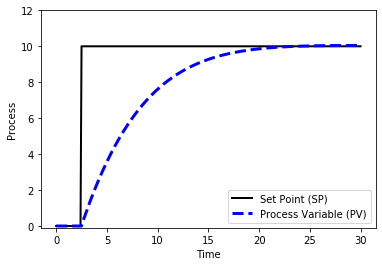

In [5]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# process model
Kp = 3.0
taup = 5.0
def process(y,t,u,Kp,taup):
    # Kp = process gain
    # taup = process time constant
    dydt = -y/taup + Kp/taup * u
    return dydt

# Specify number of steps
ns = 300

# Define time points
t = np.linspace(0,ns/10,ns+1)
delta_t = t[1]-t[0]

# Storage for recording values
op = np.zeros(ns+1)  # controller output
pv = np.zeros(ns+1)  # process variable
e = np.zeros(ns+1)   # error
ie = np.zeros(ns+1)  # integral of the error
dpv = np.zeros(ns+1) # derivative of the pv
P = np.zeros(ns+1)   # proportional
I = np.zeros(ns+1)   # integral
D = np.zeros(ns+1)   # derivative
sp = np.zeros(ns+1)  # set point
sp[25:] = 10

# PID (starting point)
Kc = 1.0/Kp
tauI = taup
tauD = 0.0

# PID (tuning)
Kc = Kc * 1
tauI = tauI / 1
tauD = 1.0

# Upper and Lower limits on OP
op_hi = 10.0
op_lo = 0.0

# Loop through time steps    
for i in range(0,ns):

    # Error
    e[i] = sp[i] - pv[i]

    # Calculate integral and derivative terms
    if i >= 1: 
        dpv[i] = (pv[i]-pv[i-1])/delta_t
        ie[i] = ie[i-1] + e[i] * delta_t

    # PID control
    P[i] = Kc * e[i]
    I[i] = Kc/tauI * ie[i]
    D[i] = - Kc * tauD * dpv[i]
    op[i] = op[0] + P[i] + I[i] + D[i]

    # Limits
    if op[i] > op_hi:  # check upper limit
        op[i] = op_hi
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup
    if op[i] < op_lo:  # check lower limit
        op[i] = op_lo
        ie[i] = ie[i] - e[i] * delta_t # anti-reset windup

    # Integrate timestep
    y = odeint(process,pv[i],[0,delta_t],args=(op[i],Kp,taup))

    # Set new start point
    pv[i+1] = y[-1]

# Save last point
op[ns] = op[ns-1]
ie[ns] = ie[ns-1]
P[ns] = P[ns-1]
I[ns] = I[ns-1]
D[ns] = D[ns-1]

# plot results
plt.figure(1)
plt.plot(t,sp,'k-',linewidth=2)
plt.plot(t,pv,'b--',linewidth=3)
plt.legend(['Set Point (SP)','Process Variable (PV)'],loc='best')
plt.ylabel('Process')
plt.ylim([-0.1,12])
plt.xlabel('Time')
plt.show()